# Attack Attemp 1

First attempt at training the GAN D/G to provide **valid** and **representable** data from unknown classes

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params (MUST MATCH Blackbox Evaluator PARAMS)
num_classes = 10
save_every = 1

# Black-box params (optimized for MNIST)
best_depth = 9
best_filters = 33
best_dense = 110

# GAN params
gan_epochs = 1
gan_batch_size = 256 # 60
noise_dim = 100

# Split Learning params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

split_minibatch_size = None                     # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
split_batches_per_train_step = 20               # after averaging the gradients from X clients, we will apply them to the model
split_epochs = 1
shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_train /= 255    # range is [0, 1]
x_test = (x_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


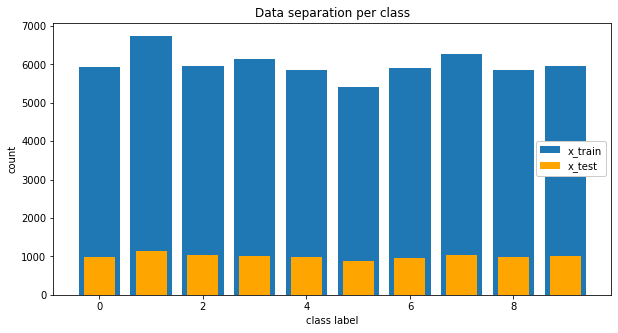

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

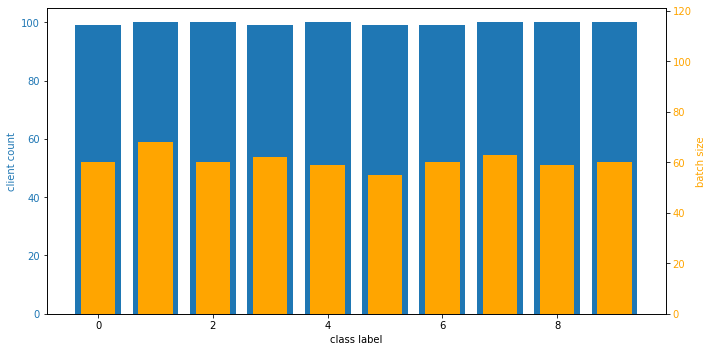

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

#### Batch and shuffle automatically

In [10]:
# Batch and shuffle the data
gan_train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(gan_batch_size)

## Build Model

In [11]:
# def start_piece(input_layer, filters=4):
#     assert filters >= 1
    
#     h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(input_layer)
    
#     return h

# def blackbox_piece(h, depth=1, filters=4):
#     assert depth >= 1
#     assert filters >= 1
    
#     # for now, we will just give the black-box all the CNN layers
#     for i in range(depth-1):
#         h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(h)
    
#     return h

# def approximator_piece(h, depth=1, filters=4):
#     assert depth >= 1
#     assert filters >= 1
    
#     # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
#     h = blackbox_piece(h, depth, filters)
    
#     return h

# def end_piece(h, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = MaxPooling2D(pool_size=(2, 2))(h)
#     h = Dropout(0.25)(h, training=training)
#     h = Flatten()(h)
#     h = Dense(dense_breadth, activation='relu')(h)
#     h = Dropout(0.5)(h, training=training)
#     output_layer = Dense(num_classes, activation='softmax')(h)
    
#     return output_layer

In [12]:
# def split_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = start_piece(input_layer, filters)
#     h = blackbox_piece(h, depth, filters)
#     output_layer = end_piece(h, dense_breadth, training)
    
#     return output_layer

# def discriminator_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = start_piece(input_layer, filters)
#     h = approximator_piece(h, depth, filters)
#     output_layer = end_piece(h, dense_breadth, training)
    
#     return output_layer

# def generator_model(input_layer, training=True):
#     h = Dense(7*7*256, use_bias=False, input_shape=(100,))(input_layer)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
#     h = Reshape((7, 7, 256))(h)
    
#     h = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(h)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
    
#     h = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(h)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
    
#     output_layer = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(h)
    
#     return output_layer
    
# #     model = tf.keras.Sequential()
# #     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Reshape((7, 7, 256)))
# #     assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

# #     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
# #     assert model.output_shape == (None, 7, 7, 128)
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
# #     assert model.output_shape == (None, 14, 14, 64)
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
# #     assert model.output_shape == (None, 28, 28, 1)

In [13]:
# TODO: remove this!!!
# num_classes = 1

In [14]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece_(input_shape, filters=4):
    assert filters >= 1
    
    model = tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    return model

def blackbox_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
    
    return model

def approximator_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
    model = blackbox_piece_(model, depth, filters)
    
    return model

def end_piece_(model, dense_breadth=128):
    assert dense_breadth >= num_classes
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense_breadth, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Graph Creation

In [15]:
class GAN:
    
    def __init__(self, input_shape, depth, filters, dense, batch_size, noise_dim=100):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        self.batch_size = batch_size
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.discriminator = self.discriminator_model(input_shape, depth, filters, dense)
        self.generator = self.generator_model(noise_dim)
        
        # define loss function (TODO: change to MSE)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        # define optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # seed for image generation
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        
    def train(self, dataset):
        for image_batch in dataset:
            self.train_step(image_batch)
            
    def generate_images(self):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = self.generator(self.seed, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
            plt.axis('off')

        plt.show()
        
    def discriminator_model(self, input_shape, depth=1, filters=4, dense_breadth=128):
        assert depth >= 1
        assert filters >= 1
        assert dense_breadth >= num_classes

        model = start_piece_(input_shape, filters)
        model = approximator_piece_(model, depth, filters)
        model = end_piece_(model, dense_breadth)

        return model
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_model(self, noise_dim=100):
        model = tf.keras.Sequential()
        
        model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        # using softmax instead of tanh now since our data range is from [0, 1] instead of [-1, 1]
        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        return model
    
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

In [24]:
class SplitLearning:
    
    def __init__(self, input_shape, depth, filters, dense, minibatch_size, batches_per_train_step):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.minibatch_size = minibatch_size
        
        self.batches_per_train_step = batches_per_train_step
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.model = self.split_model(input_shape, depth, filters, dense)
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # setup ops
        self.setup_ops()
        
    def train(self):
        
        batch_idxs = list(range(len(x_batches)))
        if shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
                        
        self.train_step(batch_idxs)
        
    def split_model(self, input_shape, depth=1, filters=4, dense_breadth=128):
        assert depth >= 1
        assert filters >= 1
        assert dense_breadth >= num_classes

        model = start_piece_(input_shape, filters)
        model = blackbox_piece_(model, depth, filters)
        model = end_piece_(model, dense_breadth)

        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            loss_value = self.model_loss(targets, self.model(inputs))
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads):
        self.accum_vars = [self.accum_vars[i].assign_add(grad) for i, grad in enumerate(grads)]
        self.accum_counter.assign_add(1.0)
        
    def optimize(self):
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        self.accum_vars = [tv.assign(tf.zeros_like(tv)) for tv in self.accum_vars]
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
#         self.zero_ops = [tv.assign(tf.zeros_like(tv)) for tv in self.accum_vars]
        
#         # Fetch a list of our network's trainable parameters.
#         self.trainable_vars = self.model.trainable_variables

#         # Create variables to store accumulated gradients
#         self.accumulators = [
#             tf.Variable(
#                 tf.zeros_like(tv.initialized_value()),
#                 trainable=False
#             ) for tv in self.trainable_vars
#         ]

#         # Create a variable for counting the number of accumulations
#         self.accumulation_counter = tf.Variable(0.0, trainable=False)

#         # Compute gradients; grad_pairs contains (gradient, variable) pairs
#         self.grad_pairs = self.optimizer.compute_gradients(self.cross_entropy, self.trainable_vars)

#         # Create operations which add a variable's gradient to its accumulator.
#         self.accumulate_ops = [
#             accumulator.assign_add(
#                 grad
#             ) for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)
#         ]

#         # The final accumulation operation is to increment the counter
#         self.accumulate_ops.append(self.accumulation_counter.assign_add(1.0))

#         # Update trainable variables by applying the accumulated gradients
#         # divided by the counter. Note: apply_gradients takes in a list of 
#         # (grad, var) pairs
#         self.train_step_ = self.optimizer.apply_gradients(
#             [(accumulator / self.accumulation_counter, var) \
#                 for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
#         )

#         # Accumulators must be zeroed once the accumulated gradient is applied.
#         self.zero_ops = [
#             accumulator.assign(
#                 tf.zeros_like(tv)
#             ) for (accumulator, tv) in zip(self.accumulators, self.trainable_vars)
#         ]

#         # Add one last op for zeroing the counter
#         self.zero_ops.append(self.accumulation_counter.assign(0.0))
        
#     @tf.function
#     def accumulate_ops(x_minibatch, y_minibatch):
#         logits = self.model(x_minibatch, training=True)
#         return self.accumulate_ops(logits, y_minibatch)
    
#     @tf.function
#     def apply_accumulated():
#         return self.train_step_
    
#     @tf.function
#     def zero_out():
#         return self.zero_ops
        
    @tf.function
    def train_step(self, batch_idxs):
                        
        print(len(batch_idxs))
        for i, batch_idx in tqdm_notebook(enumerate(batch_idxs)):
            class_idx, x_batch = x_batches[batch_idx]
            _, y_batch = y_batches[batch_idx]

            # Iterate over the client's batch in minibatches:
            j = 0
            while(j < len(x_batch)):
                if self.minibatch_size is None:
                    # use whole batch (no minibatch)
                    x_minibatch = x_batch
                    y_minibatch = y_batch
                else:
                    x_minibatch = x_batch[j:(j+self.minibatch_size)]
                    y_minibatch = y_batch[j:(j+self.minibatch_size)]
                    
                # run the gradients
                loss_value, grads = self.grad(x_minibatch, y_minibatch)
                
                # accumulate them
                self.accumulate_grads(grads)
                
#                 with tf.GradientTape() as tape:
#                     logits = self.model(x_minibatch, training=True)
#                     self.accumulate_ops(logits, y_minibatch, training=True)
                    
                    # TODO: extra loss calculation here
#                     loss_value = self.split_loss(y_minibatch, logits)
        
#                 ####################################################################
#                 with tf.GradientTape() as tape:
# #                     logits = self.model(x_minibatch, training=True)
# #                     self.tvs = self.model.trainable_variables
                    
#                     # Create variables to store accumulated gradients
# #                     accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]
# #                     zero_ops = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
# #                     loss_value = self.split_loss(y_minibatch, logits)

#                 # loss_history.append(loss_value.numpy().mean())
#                 grads = tape.gradient(loss_value, tvs)
#                 #print(grads[0].shape)
#                 #print(accum_vars[0].shape)
#                 accum_ops = [accum_vars[i].assign_add(grad) for i, grad in enumerate(grads)]
#                 ####################################################################
                
                # add acc and loss metrics for batch:
#                 accs_train.append(acc_train)
#                 losses_train.append(np.mean(loss_train))

                if self.minibatch_size is None:
                    break
                else:
                    j += self.minibatch_size
                
            # perform a train step every batches_per_train_step number of batches:
            if (i > 0 and i % self.batches_per_train_step == 0) or i == len(batch_idxs) - 1:
                # Run the train_step ops to update the weights based on our accumulated gradients
                self.optimize()
                self.zero_out()
                
#                 optimizer.apply_gradients(zip(grads, model.trainable_variables))
#                 self.zero_out()
#                 self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [25]:
class SplitLearningGAN:
    
    def __init__(self, input_shape, gan_dataset, 
                 depth, filters, dense, 
                 noise_dim, gan_batch_size, gan_epochs, 
                 split_minibatch_size, split_batches_per_train_step, split_epochs):#, attack_epochs):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        
        self.gan_batch_size = gan_batch_size
        self.gan_epochs = gan_epochs
        self.gan_dataset = gan_dataset
        
        self.split_minibatch_size = split_minibatch_size
        self.split_batches_per_train_step = split_batches_per_train_step
        self.split_epochs = split_epochs
#         self.attack_epochs = attack_epochs
        
        self.gan = GAN(self.input_shape, self.depth, self.filters, self.dense, self.gan_batch_size, self.noise_dim)
        self.split = SplitLearning(self.input_shape, self.depth, self.filters, self.dense,
                                   self.split_minibatch_size, self.split_batches_per_train_step)
        
    def train_system(self):
        
        # test GAN training:
#         for e in tqdm_notebook(range(self.gan_epochs)):
#             self.gan.train(self.gan_dataset)
#         self.gan.generate_images()
            
        # now test Split Learning training:
        for e in range(self.split_epochs):
            self.split.train()
        self.split.evaluate()

In [26]:
slg = SplitLearningGAN(input_shape, gan_train_dataset, 
                       best_depth, best_filters, best_dense, 
                       noise_dim, gan_batch_size, gan_epochs, 
                       split_minibatch_size, split_batches_per_train_step, split_epochs)

In [27]:
slg.train_system()

996


KeyboardInterrupt: 